# 7.1 언어 모델을 사용한 문장 생성

7.1.2 문장 생성 구현

In [2]:
import numpy as np
from functions import softmax
from time_layers import *
import pickle
import os
from utils import to_gpu, to_cpu

class Rnnlm:
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4*H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
    
    def predict(self, xs): # 7장에서 수행하는 문장 생성에 사용
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.lstm_layer.reset_state()

    def save_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)

    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)

class BaseModel:
    def __init__(self):
        self.params, self.grads = None, None

    def forward(self, *args):
        raise NotImplementedError

    def backward(self, *args):
        raise NotImplementedError

    def save_params(self, file_name=None):
        if file_name is None:
            file_name = self.__class__.__name__ + '.pkl'

        params = [p.astype(np.float16) for p in self.params]
        if GPU:
            params = [to_cpu(p) for p in params]

        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name=None):
        if file_name is None:
            file_name = self.__class__.__name__ + '.pkl'

        if '/' in file_name:
            file_name = file_name.replace('/', os.sep)

        if not os.path.exists(file_name):
            raise IOError('No file: ' + file_name)

        with open(file_name, 'rb') as f:
            params = pickle.load(f)

        params = [p.astype('f') for p in params]
        if GPU:
            params = [to_gpu(p) for p in params]

        for i, param in enumerate(self.params):
            param[...] = params[i]

class BetterRnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=650,
                 hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4*H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4*H).astype('f')
        lstm_Wx2 = (rn(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4*H).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 세 가지 개선!
        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b) # 가중치 공유!!
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

In [7]:
class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1) # predict는 미니배치 처리하므로 2차원 배열
            score = self.predict(x)
            p = softmax(score.flatten())

            sampled = np.random.choice(len(p), size=1, p=p)
            if(skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x.item()))
        
        return word_ids

In [10]:
# 학습하지 않은 상태로 문장 생성
from data import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
# model.load_params(Rnnlm.pkl)

# 시작(start) 문자와 건너뜀(skip) 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '\n')
print(txt)

you carson afghan journalism washington-based guarantees copying republics electricity teagan albert designed utterly vowed lows survived both poughkeepsie powerful economists rise drain extensive wang face-to-face reversal model sheraton bikes reed sites stepping german converted interfere performers rupert pretax words netherlands risks conservatorship rural recruiting trains privately vietnam applies crest stuart california saatchi solved comair play shelf tissue sites solar negotiating consistent distribution bond-equivalent permissible disappears relating applications dorfman diet quota rumors immune syrian perpetual endangered amounts hurry solely tyler put dialing contemporary homosexual daimler-benz backgrounds calgary tilt subscribe notify over-the-counter vitro becoming fix ontario agreeing efforts furniture peace pierre processors


In [12]:
# 학습한 모델로 문장 생성
from data import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params('Rnnlm.pkl')

# 시작(start) 문자와 건너뜀(skip) 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '\n')
print(txt)

you ogilvy ariz. stunning johnson jose support bargain gatt lab notwithstanding dunes landscape drivers notable random louis fiercely jr. yearly pesticides understanding last historic suspension payment omni daniel appellate reinforcing reflects norway maker rocket enjoying welfare widespread k. ipo establishing memorandum reopen conventional unwilling polly insure gandhi hazard opinion hope blocked capture unusual lure fairfield definitively seen active prosecutor murdoch competition fasteners royalty preamble disorders rebel improved allegations lid snack-food concerning potential goldberg grip bill landed fabric association mason bnl restructurings designing shea filipino bank packaged formally interested legislature intensive harder justifies lackluster merrill solo row tony passage eastman packed


7.1.3 더 좋은 문장으로

In [13]:
class BetterRnnlmGen(BetterRnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1) # predict는 미니배치 처리하므로 2차원 배열
            score = self.predict(x)
            p = softmax(score.flatten())

            sampled = np.random.choice(len(p), size=1, p=p)
            if(skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x.item()))
        
        return word_ids

In [15]:
# 더 좋은 RNNLM으로 문장 생성
from data import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = BetterRnnlmGen()
model.load_params('BetterRnnlm.pkl')

# 시작(start) 문자와 건너뜀(skip) 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '\n')
print(txt)

you 'll realize it 's very good
 she predicted that ps of new hampshire has unsuccessfully received numerous time including others without permission and protect some admitting violations
 gulf maynard corp. said it has incorrectly fully full public gifts of their cellular properties in both areas as november
 the move was insufficient and mca 's third-largest and communications proposal set aside under chapter protection to a majority of employees a group spokeswoman says
 the bill would fetch about # special pipeline plan
 the machinists union which owes the airline buy-out it has invested the company


# 7.2 seq2seq

7.2.4 덧셈 데이터

In [2]:
from data import sequence

(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt', seed=1984)
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)

print(x_train[0])
print(t_train[0])

print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]
71+118 
_189 


In [12]:
id_to_char[0], id_to_char[5]

('1', ' ')

# 7.3 seq2seq 구현

7.3.1 Encoder 클래스

In [1]:
from time_layers import *
class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4*H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]
    
    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

7.3.2 Decoder 클래스

In [2]:
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4*H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []

        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score
    
    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh
    
    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))
        return sampled

7.3.3 Seq2seq 클래스

In [3]:
class BaseModel:
    def __init__(self):
        self.params, self.grads = None, None

    def forward(self, *args):
        raise NotImplementedError

    def backward(self, *args):
        raise NotImplementedError

    def save_params(self, file_name=None):
        if file_name is None:
            file_name = self.__class__.__name__ + '.pkl'

        params = [p.astype(np.float16) for p in self.params]
        if GPU:
            params = [to_cpu(p) for p in params]

        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name=None):
        if file_name is None:
            file_name = self.__class__.__name__ + '.pkl'

        if '/' in file_name:
            file_name = file_name.replace('/', os.sep)

        if not os.path.exists(file_name):
            raise IOError('No file: ' + file_name)

        with open(file_name, 'rb') as f:
            params = pickle.load(f)

        params = [p.astype('f') for p in params]
        if GPU:
            params = [to_gpu(p) for p in params]

        for i, param in enumerate(self.params):
            param[...] = params[i]

class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]
        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dout = self.decoder.backward(dout)
        dout = self.encoder.backward(dout)
        return dout
    
    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

# 7.3.4 seq2seq 평가

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.53
| 에폭 1 |  반복 41 / 351 | 시간 0[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 1[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 1[s] | 손실 1.92
| 에폭 1 |  반복 101 / 351 | 시간 1[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 2[s] | 손실 1.85
| 에폭 1 |  반복 141 / 351 | 시간 2[s] | 손실 1.83
| 에폭 1 |  반복 161 / 351 | 시간 3[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 3[s] | 손실 1.77
| 에폭 1 |  반복 201 / 351 | 시간 3[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 4[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 4[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 4[s] | 손실 1.76
| 에폭 1 |  반복 281 / 351 | 시간 5[s] | 손실 1.75
| 에폭 1 |  반복 301 / 351 | 시간 5[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 5[s] | 손실 1.75
| 에폭 1 |  반복 341 / 351 | 시간 6[s] | 손실 1.74
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T 666 
X 1000
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1000
---
Q 600+257
T 857 
X 1000
---
Q 761+292
T 1053
X 1000
---
Q 830+597
T 1427
X 1000
---
Q 26+838

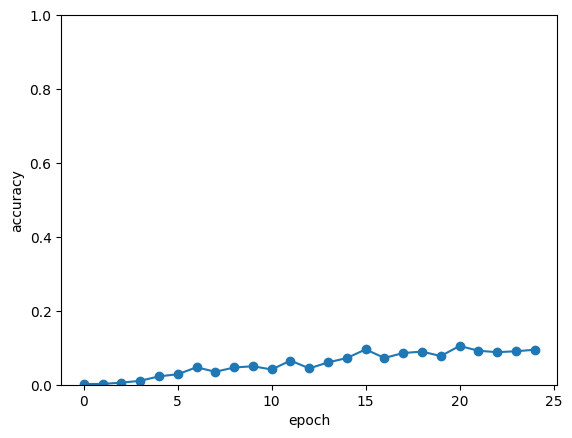

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from data import sequence
from optimizer import Adam
from trainer import Trainer
from utils import eval_seq2seq

# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = False  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()

# 7.4 seq2seq 개선

7.4.1 입력 데이터 반전(Reverse)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from data import sequence
from optimizer import Adam
from trainer import Trainer
from utils import eval_seq2seq

# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list2 = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc2 = float(correct_num) / len(x_test)
    acc_list2.append(acc2)
    print('검증 정확도 %.3f%%' % (acc2 * 100))

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.52
| 에폭 1 |  반복 41 / 351 | 시간 0[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 1[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 1[s] | 손실 1.91
| 에폭 1 |  반복 101 / 351 | 시간 1[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 2[s] | 손실 1.86
| 에폭 1 |  반복 141 / 351 | 시간 2[s] | 손실 1.84
| 에폭 1 |  반복 161 / 351 | 시간 2[s] | 손실 1.80
| 에폭 1 |  반복 181 / 351 | 시간 3[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 3[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 3[s] | 손실 1.77
| 에폭 1 |  반복 241 / 351 | 시간 4[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 4[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 4[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 5[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 5[s] | 손실 1.74
| 에폭 1 |  반복 341 / 351 | 시간 6[s] | 손실 1.73
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T 666 
X 1001
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1001
---
Q 600+257
T 857 
X 1000
---
Q 761+292
T 1053
X 1000
---
Q 830+597
T 1427
X 1000
---
Q 26+838

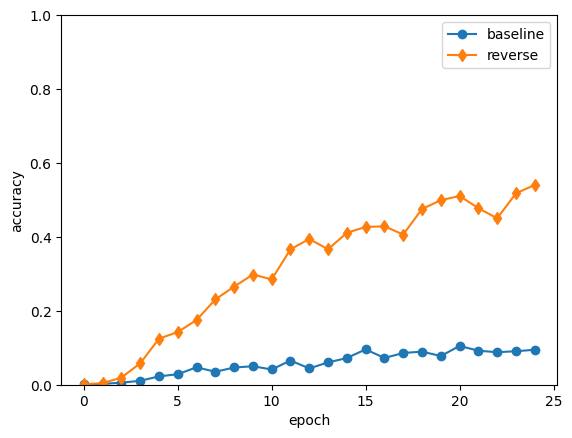

In [12]:
# 그래프 그리기
x1 = np.arange(len(acc_list))
x2 = np.arange(len(acc_list2))
plt.plot(x1, acc_list, marker='o', label='baseline')
plt.plot(x2, acc_list2, marker='d', label='reverse')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.legend()
plt.show()

### 입력 반전으로 인해 성능이 향상되는 이유
> reverse는 “기억해야 할 중요한 정보를 마지막에 두는 트릭”
\
→ encoder–decoder 사이 정보 병목을 완화함

7.4.2 엿보기(Peeky)

In [ ]:
class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4*H) / np.sqrt(H + D)).astype('f')
        lstm_Wh = (rn(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cahce = None
    
    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape

        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H)
        out = np.concatenate((hs, out), axis=2)

        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis=2)
        
        score = self.affine.forward(out)
        self.cache = H
        return score
    
    def backward(self, dscore):
        H = self.cache
        
        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H], dout[:, :, H] # concatenate한 거 분기
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H], dout[:, :, H] # concatenate한 거 분기
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1)
        return dh
    
    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())
            sampled.append(char_id)
        return sampled